## Key Highlights:

1. **Data Exploration:** Understanding the dataset by analyzing historical sales trends, missing values, and data distributions to prepare it for feature engineering.
2. **Lagged Features:** Creating historical feature representations to capture temporal dependencies in sales data. These features reveal trends and seasonality crucial for accurate time-series forecasting.
3. **Feature Engineering & Selection:** Identifying and selecting relevant features, scaling numerical values, encoding categorical variables, and testing feature importance to refine the dataset for optimal model performance.
4. **Model Training with XGBoost:** Leveraging XGBoost’s gradient boosting capabilities to build an effective sales prediction model.
5. **Validation & Performance Analysis:** Evaluating the model’s accuracy using metrics like RMSE and WMAE. Cross-validation is applied to ensure the model generalizes well to unseen data.
6. **Model Optimization & Deployment:** Strategies for improving model efficiency, reducing overfitting, and integrating the model into a production pipeline for real-world business applications.

## Approach & Model Improvements

- **Initial Feature Engineering:** Started with the given dataset, handling null values and categorizing features as numerical and categorical. This initial setup yielded a public score of approximately **47**. 
- **Incorporating Lag Features & Seasonal Cyclic Trends:** Introduced lagged sales values and cyclic seasonal sales features, which significantly improved the model and reduced the public score to **30**. 
- **Loss Function Optimization with Weights:** Integrated the provided weights into the Weighted Mean Absolute Error (WMAE) loss function, further reducing the score to **27**. 
- **Experimenting with Discounts & Sales Impact:** Analyzed the effect of discounts, maximum discounts, store closures, and holidays on sales, though these modifications had minimal impact on the overall performance.
- **Normalization & Transformation:** Applied log normalization to sell_price_main and min-max normalization to total_orders (as some values were zero). Additionally, transformed the names column by extracting common names from identifiers, leading to a final score improvement to around **25**.

I have attached the public and private scores at the end.

## Attribution & Copyright Notice:

This project is inspired by the Rohlik Sales Forecasting Challenge V2 on Kaggle. The dataset and competition details are provided by Rohlik Group and Kaggle under their respective terms of use. Any results, analysis, and insights presented in this blog post are for educational and informational purposes only. Please refer to the original [Kaggle competition page](https://www.kaggle.com/competitions/rohlik-sales-forecasting-challenge-v2/overview) for official details and dataset access. All credits for the dataset and competition organization belong to Rohlik Group and Kaggle.

In [1]:
# import Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from IPython.display import FileLink, FileLinks
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
sales_train_df = pd.read_csv("rohlik-sales-forecasting-challenge-v2/sales_train.csv")
sales_test_df = pd.read_csv("rohlik-sales-forecasting-challenge-v2/sales_test.csv")
calender_df = pd.read_csv("rohlik-sales-forecasting-challenge-v2/calendar.csv")
inventory_df = pd.read_csv("rohlik-sales-forecasting-challenge-v2/inventory.csv")
test_weights_df = pd.read_csv("rohlik-sales-forecasting-challenge-v2/test_weights.csv")

df_cal_enriched = pd.read_csv('calendar_enriched.csv')
df_cal_enriched_2025 = pd.read_csv('calendar_enriched_2025-01-05.csv')
df_cal_enriched_2025 = df_cal_enriched_2025.drop(columns = ["date_year"])

In [3]:
# Merge data
train_df = sales_train_df.merge(inventory_df, on=['unique_id', 'warehouse'], how='left')
train_df = train_df.merge(test_weights_df, on = ['unique_id'], how = 'left')
train_df = train_df.merge(df_cal_enriched_2025, on = ['date', 'warehouse'], how = 'left')
train_df = train_df.drop(columns=["availability"])
train_df.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,...,date_holiday_name,date_holiday_flag,date_shops_closed_flag,date_winter_school_holidays_flag,date_school_holidays_flag,date_days_to_next_holiday,date_days_to_shops_closed,date_day_after_closed_day,date_second_closed_day,date_day_after_two_closed_days
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,0.00000,0.0,0.0,0.0,...,NaN,0,0,0,0,19.0,19.0,0,0,0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,0.00000,0.0,0.0,0.0,...,NaN,0,0,0,0,151.0,151.0,1,0,1
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,0.00000,0.0,0.0,0.0,...,NaN,0,0,0,0,5.0,6.0,0,0,0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.20024,0.0,0.0,0.0,...,NaN,0,0,0,0,29.0,29.0,0,0,0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,0.00000,0.0,0.0,0.0,...,NaN,0,0,0,0,15.0,16.0,0,0,0


In [4]:
test_df = sales_test_df.merge(inventory_df, on=['unique_id', 'warehouse'], how='left')
test_df = test_df.merge(test_weights_df, on = ['unique_id'], how = 'left')
test_df = test_df.merge(df_cal_enriched_2025, on=['date', 'warehouse'], how='left')
test_df.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,...,date_holiday_name,date_holiday_flag,date_shops_closed_flag,date_winter_school_holidays_flag,date_school_holidays_flag,date_days_to_next_holiday,date_days_to_shops_closed,date_day_after_closed_day,date_second_closed_day,date_day_after_two_closed_days
0,1226,2024-06-03,Brno_1,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,...,NaN,0,0,0,0,33.0,147.0,0,0,0
1,1226,2024-06-11,Brno_1,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,...,NaN,0,0,0,0,25.0,139.0,0,0,0
2,1226,2024-06-13,Brno_1,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,...,NaN,0,0,0,0,23.0,137.0,0,0,0
3,1226,2024-06-15,Brno_1,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,...,NaN,0,0,0,0,21.0,135.0,0,0,0
4,1226,2024-06-09,Brno_1,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,...,NaN,0,0,0,0,27.0,141.0,0,0,0


In [5]:
print(train_df.shape)
print(test_df.shape)

(4007419, 30)
(47021, 29)


In [6]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [7]:
for df in [train_df, test_df]:
    df['year'] = df['date'].dt.year 
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)

    df['year_sin'] = np.sin(df['year'] / 1 * 2 * np.pi)
    df['year_cos'] = np.cos(df['year'] / 1 * 2 * np.pi)
    df['month_sin'] = np.sin(df['month'] / 12 * 2 * np.pi)
    df['month_cos'] = np.cos(df['month'] / 12 * 2 * np.pi)

In [8]:
train_df_sorted = train_df.sort_values(by = ['date', 'warehouse']).reset_index()
train_df_sorted = train_df_sorted.drop(columns = ["index"])
train_df_sorted.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,...,date_day_after_two_closed_days,year,month,day,dayofweek,is_weekend,year_sin,year_cos,month_sin,month_cos
0,2706,2020-08-01,Brno_1,4797.0,40.07,56.90,0.0,0.0,0.0,0.0,...,0,2020,8,1,5,1,-8.073961e-13,1.0,-0.866025,-0.5
1,5033,2020-08-01,Brno_1,4797.0,17.81,45.09,0.0,0.0,0.0,0.0,...,0,2020,8,1,5,1,-8.073961e-13,1.0,-0.866025,-0.5
2,3285,2020-08-01,Brno_1,4797.0,40.07,17.84,0.0,0.0,0.0,0.0,...,0,2020,8,1,5,1,-8.073961e-13,1.0,-0.866025,-0.5
3,1807,2020-08-01,Brno_1,4797.0,17.81,92.78,0.0,0.0,0.0,0.0,...,0,2020,8,1,5,1,-8.073961e-13,1.0,-0.866025,-0.5
4,3200,2020-08-01,Brno_1,4797.0,251.54,28.85,0.0,0.0,0.0,0.0,...,0,2020,8,1,5,1,-8.073961e-13,1.0,-0.866025,-0.5


In [9]:
test_df_sorted = test_df.sort_values(by = ['date', 'warehouse']).reset_index()
test_df_sorted = test_df_sorted.drop(columns = ["index"])
test_df_sorted.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,...,date_day_after_two_closed_days,year,month,day,dayofweek,is_weekend,year_sin,year_cos,month_sin,month_cos
0,1226,2024-06-03,Brno_1,8679.0,13.13,0.0,0.0,0.0,0.0,0.0,...,0,2024,6,3,0,0,1.585375e-14,1.0,1.224647e-16,-1.0
1,2091,2024-06-03,Brno_1,8679.0,314.64,0.0,0.0,0.0,0.0,0.0,...,0,2024,6,3,0,0,1.585375e-14,1.0,1.224647e-16,-1.0
2,5239,2024-06-03,Brno_1,8679.0,96.69,0.0,0.0,0.0,0.0,0.0,...,0,2024,6,3,0,0,1.585375e-14,1.0,1.224647e-16,-1.0
3,826,2024-06-03,Brno_1,8679.0,24.90,0.0,0.0,0.0,0.0,0.0,...,0,2024,6,3,0,0,1.585375e-14,1.0,1.224647e-16,-1.0
4,1352,2024-06-03,Brno_1,8679.0,226.09,0.0,0.0,0.0,0.0,0.0,...,0,2024,6,3,0,0,1.585375e-14,1.0,1.224647e-16,-1.0


# Exploring Data

In [10]:
train_df_sorted.columns

Index(['unique_id', 'date', 'warehouse', 'total_orders', 'sales',
       'sell_price_main', 'type_0_discount', 'type_1_discount',
       'type_2_discount', 'type_3_discount', 'type_4_discount',
       'type_5_discount', 'type_6_discount', 'product_unique_id', 'name',
       'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en',
       'L4_category_name_en', 'weight', 'date_holiday_name',
       'date_holiday_flag', 'date_shops_closed_flag',
       'date_winter_school_holidays_flag', 'date_school_holidays_flag',
       'date_days_to_next_holiday', 'date_days_to_shops_closed',
       'date_day_after_closed_day', 'date_second_closed_day',
       'date_day_after_two_closed_days', 'year', 'month', 'day', 'dayofweek',
       'is_weekend', 'year_sin', 'year_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [11]:
test_df_sorted.columns

Index(['unique_id', 'date', 'warehouse', 'total_orders', 'sell_price_main',
       'type_0_discount', 'type_1_discount', 'type_2_discount',
       'type_3_discount', 'type_4_discount', 'type_5_discount',
       'type_6_discount', 'product_unique_id', 'name', 'L1_category_name_en',
       'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en',
       'weight', 'date_holiday_name', 'date_holiday_flag',
       'date_shops_closed_flag', 'date_winter_school_holidays_flag',
       'date_school_holidays_flag', 'date_days_to_next_holiday',
       'date_days_to_shops_closed', 'date_day_after_closed_day',
       'date_second_closed_day', 'date_day_after_two_closed_days', 'year',
       'month', 'day', 'dayofweek', 'is_weekend', 'year_sin', 'year_cos',
       'month_sin', 'month_cos'],
      dtype='object')

In [12]:
print("train min date", train_df_sorted.date.min())
print("train max date", train_df_sorted.date.max())
print("test min date", test_df_sorted.date.min())
print("test max date", test_df_sorted.date.max())

train min date 2020-08-01 00:00:00
train max date 2024-06-02 00:00:00
test min date 2024-06-03 00:00:00
test max date 2024-06-16 00:00:00


In [13]:
train_df_sorted.isna().sum()

unique_id                                 0
date                                      0
warehouse                                 0
total_orders                             52
sales                                    52
sell_price_main                           0
type_0_discount                           0
type_1_discount                           0
type_2_discount                           0
type_3_discount                           0
type_4_discount                           0
type_5_discount                           0
type_6_discount                           0
product_unique_id                         0
name                                      0
L1_category_name_en                       0
L2_category_name_en                       0
L3_category_name_en                       0
L4_category_name_en                       0
weight                                    0
date_holiday_name                   3826305
date_holiday_flag                         0
date_shops_closed_flag          

In [14]:
train_df_sorted['sales'] = train_df_sorted['sales'].fillna(0)
train_df_sorted['total_orders'] = train_df_sorted['total_orders'].fillna(0)

In [15]:
test_df_sorted.isna().sum()

unique_id                               0
date                                    0
warehouse                               0
total_orders                            0
sell_price_main                         0
type_0_discount                         0
type_1_discount                         0
type_2_discount                         0
type_3_discount                         0
type_4_discount                         0
type_5_discount                         0
type_6_discount                         0
product_unique_id                       0
name                                    0
L1_category_name_en                     0
L2_category_name_en                     0
L3_category_name_en                     0
L4_category_name_en                     0
weight                                  0
date_holiday_name                   46544
date_holiday_flag                       0
date_shops_closed_flag                  0
date_winter_school_holidays_flag        0
date_school_holidays_flag         

In [16]:
train_df_sorted['date_holiday_name'].fillna( "No_Holiday", inplace = True)
test_df_sorted['date_holiday_name'].fillna( "No_Holiday", inplace = True)

In [17]:
train_df_sorted['date_holiday_name'].unique()

array(['No_Holiday', 'State Foundation Day',
       'Hungary National Day Holiday', 'Den ceske statnosti',
       'Memorial Day for the Martyrs of Arad',
       'Memorial day of the 1956 Revolution',
       'Den vzniku samostatneho ceskoslovenskeho statu', 'All Saints Day',
       'Den boje za svobodu a demokracii', 'Christmas Eve',
       '1st Christmas Day', '2nd Christmas Day', 'New Years Day',
       'Memorial Day of the Republic',
       'Memorial Day for the Victims of the Communist Dictatorships',
       'International womens day',
       'Memorial Day for the Victims of the Holocaust', 'Good Friday',
       'Easter Day', 'Easter Monday', 'Labour Day', 'Den osvobozeni',
       'Mother Day', 'National Defense Day', 'Whit sunday', 'Whit monday',
       'Day of National Unity', 'Independent Hungary Day',
       'Cyrila a Metodej', 'Jan Hus', 'Peace Festival in Augsburg',
       'Assumption of the Virgin Mary', 'German Unity Day', 'Epiphany',
       '1848 Revolution Memorial Day (Ex

In [18]:
test_df_sorted['date_holiday_name'].unique()

array(['No_Holiday', 'Day of National Unity'], dtype=object)

In [19]:
# Quick check of discount impact on sales
train_discount = train_df_sorted.copy()
train_discount['has_any_discount'] = (train_discount[['type_0_discount', 'type_1_discount', 'type_2_discount', 
                                  'type_3_discount', 'type_4_discount', 'type_5_discount', 
                                  'type_6_discount']] > 0).any(axis=1)

print("Average sales with/without discounts:")
print(train_discount.groupby('has_any_discount')['sales'].mean())

Average sales with/without discounts:
has_any_discount
False    102.968923
True     140.001062
Name: sales, dtype: float64


In [20]:
# Combine train and test
test_df_sorted['sales'] = np.nan  # Add empty sales column to test
combined_data = pd.concat([train_df_sorted, test_df_sorted]).sort_values(['date'])

In [21]:
discount_cols = ['type_0_discount', 'type_1_discount',
       'type_2_discount', 'type_3_discount', 'type_4_discount',
       'type_5_discount', 'type_6_discount']

combined_data['max_discount'] = combined_data[discount_cols].max(axis = 1)
combined_data['max_discount_type'] = combined_data[discount_cols].idxmax(axis = 1)

# Lagged Features

In [22]:
periods = [7, 14, 21, 28, 56, 112, 224, 365]
def add_lag_sales(combined_data):
    for period in periods:
        combined_data[f"sales_lag_{period}"] = combined_data.groupby("unique_id")["sales"].shift(period)
        combined_data.groupby('unique_id')[f"sales_lag_{period}"].fillna(method='ffill')
        combined_data[f"sales_lag_{period}"] = combined_data[f"sales_lag_{period}"].fillna(0)  # Fill remaining NaNs with 0
    return combined_data

In [23]:
combined_data = add_lag_sales(combined_data)

In [24]:
combined_data.tail()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,...,max_discount,max_discount_type,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_56,sales_lag_112,sales_lag_224,sales_lag_365
44861,796,2024-06-16,Frankfurt_1,1189.0,NaN,3.22,0.0,0.0,0.0,0.0,...,0.00000,type_0_discount,0.0,24.32,21.01,0.00,18.81,17.58,34.31,60.89
44862,3975,2024-06-16,Frankfurt_1,1189.0,NaN,5.38,0.0,0.0,0.0,0.0,...,0.17560,type_6_discount,0.0,75.20,59.05,108.75,69.34,44.30,0.00,0.00
44863,331,2024-06-16,Frankfurt_1,1189.0,NaN,0.64,0.0,0.0,0.0,0.0,...,0.00000,type_0_discount,0.0,18.24,6.30,55.05,7.19,48.90,39.67,18.15
44853,4835,2024-06-16,Frankfurt_1,1189.0,NaN,0.89,0.0,0.0,0.0,0.0,...,0.10084,type_4_discount,0.0,22.30,18.91,39.32,16.77,28.37,36.52,0.00
47020,2125,2024-06-16,Prague_3,5390.0,NaN,19.44,0.0,0.0,0.0,0.0,...,0.00000,type_0_discount,0.0,19.46,14.11,8.78,7.54,10.99,14.50,11.85


In [25]:
combined_data.dtypes

unique_id                                    int64
date                                datetime64[ns]
warehouse                                   object
total_orders                               float64
sales                                      float64
sell_price_main                            float64
type_0_discount                            float64
type_1_discount                            float64
type_2_discount                            float64
type_3_discount                            float64
type_4_discount                            float64
type_5_discount                            float64
type_6_discount                            float64
product_unique_id                            int64
name                                        object
L1_category_name_en                         object
L2_category_name_en                         object
L3_category_name_en                         object
L4_category_name_en                         object
weight                         

In [26]:
combined_data['sell_price_main'] = np.log(combined_data['sell_price_main'])
# Min-Max Normalization
combined_data['total_orders'] = (combined_data['total_orders'] - combined_data['total_orders'].min()) / (combined_data['total_orders'].max() - combined_data['total_orders'].min())
combined_data['common_name'] = combined_data['name'].apply(lambda x: x[:x.find('_')])
combined_data = combined_data.drop(columns = ['name'])

In [27]:
# Ensuring correct datatypes

for col in combined_data.select_dtypes("object").columns:
    combined_data[col] = combined_data[col].astype('category')

In [28]:
# Train Test dataframe split 
train_end_date = "2024-06-02"
test_start_date = "2024-06-03"
test_end_date = "2024-06-17"

X_train_df = (combined_data.loc[(combined_data['date'] >= '2020-08-01')
                     & (combined_data['date'] <= "2024-05-19")]).drop(columns = ['sales'])
y_train = combined_data.loc[(combined_data['date'] >= '2020-08-01')
                     & (combined_data['date'] <= "2024-05-19")]["sales"]

X_val_df = (combined_data.loc[(combined_data['date'] >= '2024-05-20')
                     & (combined_data['date'] <= "2024-06-02")]).drop(columns = ['sales'])
y_val = combined_data.loc[(combined_data['date'] >= '2024-05-20')
                     & (combined_data['date'] <= "2024-06-02")]["sales"]

# X_test_id = combined_data.loc[combined_data['date'] >= '2024-06-03']["unique_id"]
X_test_df = combined_data.loc[combined_data['date'] >= '2024-06-03'].drop(columns=["sales"])
y_test = combined_data.loc[combined_data['date'] >= '2024-06-03']["sales"]

In [29]:
X_train_df.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,...,max_discount_type,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_56,sales_lag_112,sales_lag_224,sales_lag_365,common_name
0,2706,2020-08-01,Brno_1,0.259648,4.041295,0.00000,0.0,0.0,0.0,0.0,...,type_0_discount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Potato
1281,2964,2020-08-01,Prague_2,0.131204,4.021415,0.30048,0.0,0.0,0.0,0.0,...,type_0_discount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Apple
1280,3305,2020-08-01,Prague_2,0.131204,3.687879,0.00000,0.0,0.0,0.0,0.0,...,type_0_discount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bread
1279,4474,2020-08-01,Prague_2,0.131204,4.528937,0.00000,0.0,0.0,0.0,0.0,...,type_0_discount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beef
1278,273,2020-08-01,Prague_2,0.131204,4.828794,0.00000,0.0,0.0,0.0,0.0,...,type_0_discount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mix meat


In [30]:
X_test_df.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,...,max_discount_type,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_lag_56,sales_lag_112,sales_lag_224,sales_lag_365,common_name
2259,1618,2024-06-03,Prague_2,0.308796,6.116642,0.0,0.0,0.0,0.0,0.0,...,type_0_discount,49.69,46.38,103.65,39.14,61.72,16.09,29.45,20.29,Blueberry
2258,1356,2024-06-03,Prague_2,0.308796,5.178576,0.0,0.0,0.0,0.0,0.0,...,type_0_discount,15.77,43.47,40.57,41.52,13.99,23.11,11.17,23.87,Pork
2257,1497,2024-06-03,Prague_2,0.308796,3.201933,0.0,0.0,0.0,0.0,0.0,...,type_0_discount,117.68,81.95,134.23,99.43,102.14,116.25,100.46,36.62,Coriander
2252,52,2024-06-03,Prague_2,0.308796,3.934371,0.0,0.0,0.0,0.0,0.0,...,type_0_discount,267.51,174.19,230.69,220.49,142.42,40.06,0.00,0.00,Raspberry
2255,600,2024-06-03,Prague_2,0.308796,3.196221,0.0,0.0,0.0,0.0,0.0,...,type_0_discount,188.33,174.99,159.74,167.73,177.90,245.82,116.98,62.36,Celery


In [31]:
print(X_train_df.shape)
print(y_test.shape)
print(X_test_df.shape)

(3960100, 48)
(47021,)
(47021, 48)


In [32]:
train_df_sorted['total_orders'].min()

0.0

# Training and Prediction

In [33]:
X = X_train_df.drop(columns = ["unique_id", "date", "weight", "max_discount", "max_discount_type"])
weights = X_train_df["weight"]

In [34]:
def wmae_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    weight = dtrain.get_weight()
    ab = np.abs(y_true - y_pred)
    wmae = np.sum(weight*ab)/np.sum(weight)
    return "WMAE", float(wmae)

In [35]:
params = {
    'early_stopping_rounds':10,
    "objective": "reg:absoluteerror", # MAE loss function
    "eta": 0.021796506746095975,
    "max_depth": 20,
    "random_state": 42,
    "gamma": 0.1,
    "subsample": 0.6,
    "device": 'cuda'
}
num_boost_round = 1000

In [36]:
# Convert data into DMatrix (XGBoost format)
dtrain = xgb.DMatrix(X, label=y_train, weight=weights, missing=np.nan, enable_categorical=True)

In [37]:
# Train model with WMAE metric
model = xgb.train(
    params, dtrain, num_boost_round=num_boost_round, 
    feval=wmae_metric,  # Custom evaluation function
    maximize=False,  # Minimize WMAE
    evals=[(dtrain, "train")],  # Monitor training loss
    verbose_eval=20  # Show loss every 20 rounds
)

[0]	train-mae:55.91305	train-WMAE:55.91302
[20]	train-mae:42.06652	train-WMAE:42.06648
[40]	train-mae:32.08983	train-WMAE:32.08983
[60]	train-mae:25.33954	train-WMAE:25.33955
[80]	train-mae:20.93083	train-WMAE:20.93082
[100]	train-mae:18.06270	train-WMAE:18.06269
[120]	train-mae:16.13130	train-WMAE:16.13129
[140]	train-mae:14.74775	train-WMAE:14.74775
[160]	train-mae:13.79109	train-WMAE:13.79109
[180]	train-mae:13.10327	train-WMAE:13.10328
[200]	train-mae:12.54735	train-WMAE:12.54734
[220]	train-mae:12.11845	train-WMAE:12.11844
[240]	train-mae:11.76647	train-WMAE:11.76647
[260]	train-mae:11.49795	train-WMAE:11.49794
[280]	train-mae:11.20214	train-WMAE:11.20214
[300]	train-mae:10.94051	train-WMAE:10.94050
[320]	train-mae:10.71524	train-WMAE:10.71523
[340]	train-mae:10.52527	train-WMAE:10.52527
[360]	train-mae:10.35225	train-WMAE:10.35225
[380]	train-mae:10.19986	train-WMAE:10.19986
[400]	train-mae:10.07084	train-WMAE:10.07084
[420]	train-mae:9.95145	train-WMAE:9.95144
[440]	train-mae:9.

In [38]:
y_pred = model.predict(dtrain)

In [39]:
abs(y_pred - y_train).max()

17655.06185546875

In [40]:
abs(y_pred - y_train).min()

0.0

In [41]:
X_train_df.shape

(3960100, 48)

In [42]:
# Convert data into DMatrix (XGBoost format)
val_weights = X_val_df["weight"]
dval = xgb.DMatrix(X_val_df.drop(columns = ["unique_id", "date", "weight", "max_discount", "max_discount_type"]), label=y_val, weight=val_weights, missing=np.nan, enable_categorical=True)
y_val_hat = model.predict(dval)

In [43]:
wmae_val = wmae_metric(y_val,dval)
wmae_val

('WMAE', 1.7183292336662488e-06)

In [44]:
abs(y_val - y_val_hat).max()

7225.623242187499

In [45]:
dtest = xgb.DMatrix(X_test_df.drop(columns = ["unique_id", "date", "weight", "max_discount", "max_discount_type"]), enable_categorical=True)
sales_hat = model.predict(dtest)

In [46]:
# prediction processing
unique_id = X_test_df["unique_id"].astype('string')
date = X_test_df["date"].astype('string')
test_id = unique_id + "_" +  date

df_sub = pd.DataFrame({
    "id": test_id,
    "sales_hat": sales_hat.astype("int64")
})

In [47]:
df_sub.to_csv("submission_remove_max_discount.csv", index=False)

<Figure size 15000x1200 with 0 Axes>

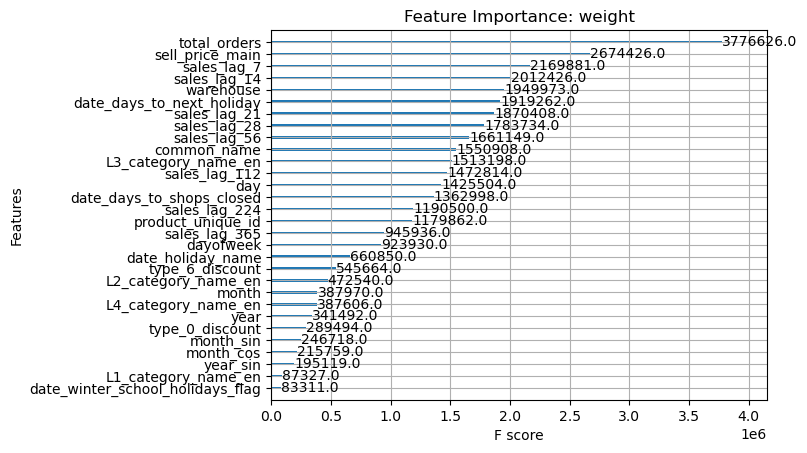

In [48]:
# Plot feature importance: weight
# How ofter feature is used in split
plt.figure(figsize=(150,12))
xgb.plot_importance(model, importance_type="weight",max_num_features=30, title="Feature Importance: weight")
plt.show()

<Figure size 15000x1200 with 0 Axes>

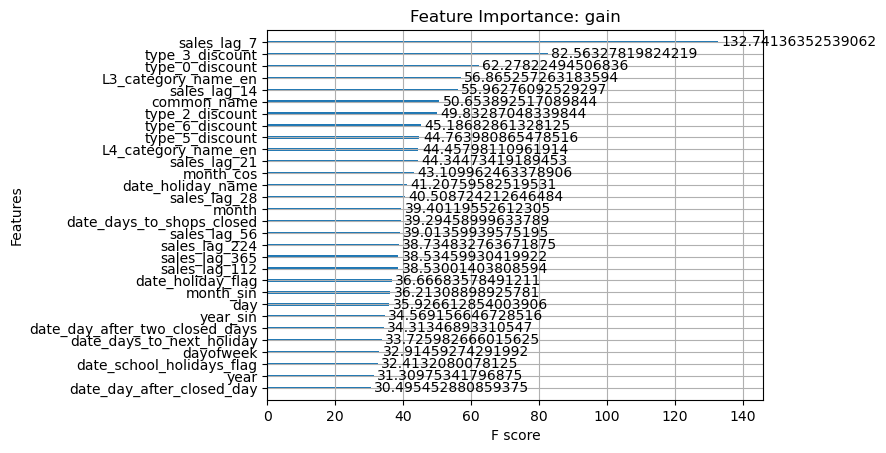

In [49]:
# Plot feature importance: gain
# how much feature improves split
plt.figure(figsize=(150,12))
xgb.plot_importance(model, importance_type="gain",max_num_features=30, title="Feature Importance: gain")
plt.show()

<Figure size 15000x1200 with 0 Axes>

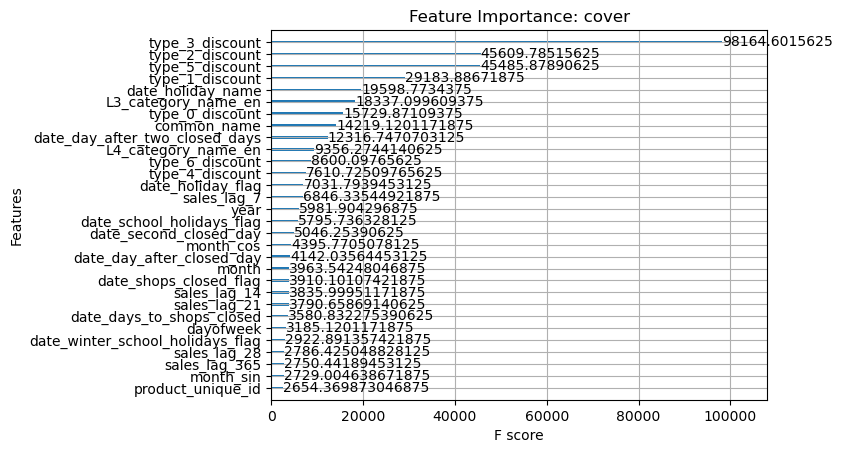

In [50]:
# Plot feature importance: cover
# No of samples affected by features
plt.figure(figsize=(150,12))
xgb.plot_importance(model, importance_type="cover",max_num_features=30, title="Feature Importance: cover")
plt.show()

# Private and public scores on Kaggle:

In [3]:
%%html
<style>
table {float:left}
</style>

<div align="left">

| Step                                      | Public Score | Private Score |
|-------------------------------------------|-------------|--------------|
| **Initial Feature Engineering**           | 48.03       | 47.66        |
| **Lag Features & Seasonal Cyclic Trends** | 30.60       | 30.53        |
| **Loss Function Optimization with Weights** | 27.318      | 27.398       |
| **Discounts & Sales Impact Analysis**     | 27.131      | 27.18        |
| **Normalization & Transformation**        | 25.69       | 25.33        |

</div>
